<a href="https://colab.research.google.com/github/jlonge4/gen_ai_utils/blob/main/flux_kontext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accelerating FLUX.1-Kontext Inference with `torch.compile` and EFS Caching

This notebook demonstrates how to significantly reduce inference time for the FLUX.1-Kontext model using `torch.compile`. By compiling the model, we can achieve a performance improvement, reducing the inference time from approximately 30 seconds to around 20 seconds.

Furthermore, for deployments in environments like SageMaker where multiple instances might be used, we can leverage Amazon Elastic File System (EFS) to persist compilation artifacts across instances. This allows subsequent instances to use the cached compiled graph without needing to recompile, saving valuable setup time and improving scaling efficiency.

## Compilation with `torch.compile`

The `torch.compile` function is a powerful tool in PyTorch that optimizes your model for faster execution. It works by analyzing your model's code and applying various optimizations, such as kernel fusion and graph simplification, to reduce overhead and improve performance on your target hardware.

In this notebook, we apply `torch.compile` to the `transformer` and `vae.decode` components of the `FluxKontextPipeline` to accelerate the inference process.

## EFS-Based Persistent Caching for SageMaker

When deploying models to scalable environments like SageMaker, recompiling the model on every new instance can be time-consuming. By mounting an EFS volume and configuring environment variables, we can direct the compilation caches to the persistent storage. This allows multiple instances to share the same compiled artifacts, eliminating the need for recompilation and enabling faster scaling.

The following code snippet illustrates how you can compile the FluxKontext pipeline to cut inference time by 33%.

References:
- https://modal.com/blog/flux-3x-faster

- https://huggingface.co/docs/diffusers/en/optimization/fp16#fused-projection-matrices

- https://github.com/modal-labs/modal-examples/blob/b5fbb047905382a611cb21d45aa6ddd631a1f15d/misc/flux_endpoint.py

In [ ]:
!pip install --upgrade torch torchvision torchaudio

In [ ]:
# Install diffusers from the main branch until future stable release
!pip install git+https://github.com/huggingface/diffusers.git
!pip install git+https://github.com/chengzeyi/ParaAttention.git

In [4]:
!pip show torch

Name: torch
Version: 2.7.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-cufile-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, para_attn, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


In [1]:
!nvidia-smi

Tue Jul 29 13:27:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [5]:
import os
from pathlib import Path

CACHE_DIR = Path('/content/drive/MyDrive/artifacts/flux_kontext_mega_v2')

# Set environment variables
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["TORCHINDUCTOR_FX_GRAPH_CACHE"] = "1"
os.environ["CUDA_CACHE_PATH"] = str(CACHE_DIR / ".nv_cache")
os.environ["TORCHINDUCTOR_CACHE_DIR"] = str(CACHE_DIR / ".inductor_cache")
os.environ["TRITON_CACHE_DIR"] = str(CACHE_DIR / ".triton_cache")

# Optional: Enable debug logs for PyTorch compilation/cache behavior
os.environ["TORCH_LOGS"] = "+torch._inductor.codecache"
mega_cache_path = CACHE_DIR / ".mega_cache"

In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [1]:
import torch
from diffusers import FluxKontextPipeline
from diffusers.utils import load_image

pipe = FluxKontextPipeline.from_pretrained("black-forest-labs/FLUX.1-Kontext-dev", torch_dtype=torch.bfloat16)
pipe.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


FluxKontextPipeline {
  "_class_name": "FluxKontextPipeline",
  "_diffusers_version": "0.35.0.dev0",
  "_name_or_path": "black-forest-labs/FLUX.1-Kontext-dev",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "FluxTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [2]:
input_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/cat.png")

In [3]:
%%time
image = pipe(
  image=input_image,
  prompt="Add a hat to the cat",
  guidance_scale=2.5
).images[0]


  0%|          | 0/28 [00:00<?, ?it/s]

CPU times: user 22.3 s, sys: 9.09 s, total: 31.3 s
Wall time: 31.4 s


Compile graphs (takes approx 15 min)

In [9]:
# If compilation has previously been performed
if mega_cache_path.exists():
    with open(mega_cache_path, "rb") as f:
        artifact_bytes = f.read()
    if artifact_bytes:
        torch.compiler.load_cache_artifacts(artifact_bytes)
        print("Loaded torch mega-cache artifacts")
else:
    print("Torch mega-cache artifacts not found, will generate new cache")

Loaded torch mega-cache artifacts


In [ ]:
# The order of events here matters
from para_attn.first_block_cache.diffusers_adapters import apply_cache_on_pipe

torch._inductor.config.conv_1x1_as_mm = True
torch._inductor.config.coordinate_descent_check_all_directions = True
torch._inductor.config.coordinate_descent_tuning = True
torch._inductor.config.disable_progress = False
torch._inductor.config.epilogue_fusion = False
torch._inductor.config.shape_padding = True

# This wont work with flux kontext at this time
# apply_cache_on_pipe(
#     pipe,
#     residual_diff_threshold=0.08,
# )

# # MONKEY PATCH FOR PARA ATTN
# # monkey-patch torch inductor remove_noop_ops pass for para-attn dynamic compilation
# # swallow AttributeError: 'SymFloat' object has no attribute 'size' and return false
# from torch._inductor.fx_passes import post_grad

# if not hasattr(post_grad, "_orig_same_meta"):
#     post_grad._orig_same_meta = post_grad.same_meta

#     def _safe_same_meta(node1, node2):
#         try:
#             return post_grad._orig_same_meta(node1, node2)
#         except AttributeError as e:
#             if "SymFloat" in str(e) and "size" in str(e):
#                 # return not the same, instead of crashing
#                 return False
#             raise

#     post_grad.same_meta = _safe_same_meta

pipe.transformer.fuse_qkv_projections()
pipe.vae.fuse_qkv_projections()
pipe.transformer.to(memory_format=torch.channels_last)
pipe.vae.to(memory_format=torch.channels_last)

# Mark layers for compilation with dynamic shapes enabled.
pipe.transformer = torch.compile(
    pipe.transformer, mode="max-autotune-no-cudagraphs",
)
pipe.vae.decode = torch.compile(
    pipe.vae.decode, mode="max-autotune-no-cudagraphs",
)

# kickoff compilation
pipe(
  image=input_image,
  prompt="Add a hat to the cat",
)

# Only use this section if compiling artifacts for the first time

In [18]:
# Use for first time compilation to get artifacts
artifact_bytes, cache_info  = torch.compiler.save_cache_artifacts()

In [19]:
with open(mega_cache_path, "wb") as f:
    f.write(artifact_bytes)

In [20]:
with open(mega_cache_path, "rb") as f:
    artifact_bytes_2 = f.read()

if artifact_bytes_2:
    assert artifact_bytes == artifact_bytes_2
    # torch.compiler.load_cache_artifacts(artifact_bytes)

In [21]:
# sanity check
!ls -al /content/drive/MyDrive/artifacts/flux_kontext_mega_v2
!ls -al /content/drive/MyDrive/artifacts/flux_kontext_mega_v2/.mega_cache

total 129444
drwx------  620 root root      4096 Jul 29 12:48 .inductor_cache
-rw-------    1 root root 132538052 Jul 29 12:52 .mega_cache
drwx------    2 root root      4096 Jul 29 12:39 .nv_cache
drwx------ 1935 root root      4096 Jul 29 12:51 .triton_cache
-rw------- 1 root root 132538052 Jul 29 12:52 /content/drive/MyDrive/artifacts/flux_kontext_mega_v2/.mega_cache


# Run inference once more to check speedup (22s vs 31s)

In [13]:
%%time
image = pipe(
  image=input_image,
  prompt="Add a hat to the cat",
  guidance_scale=2.5
).images[0]

  0%|          | 0/28 [00:00<?, ?it/s]

CPU times: user 15.8 s, sys: 6.77 s, total: 22.6 s
Wall time: 22.4 s


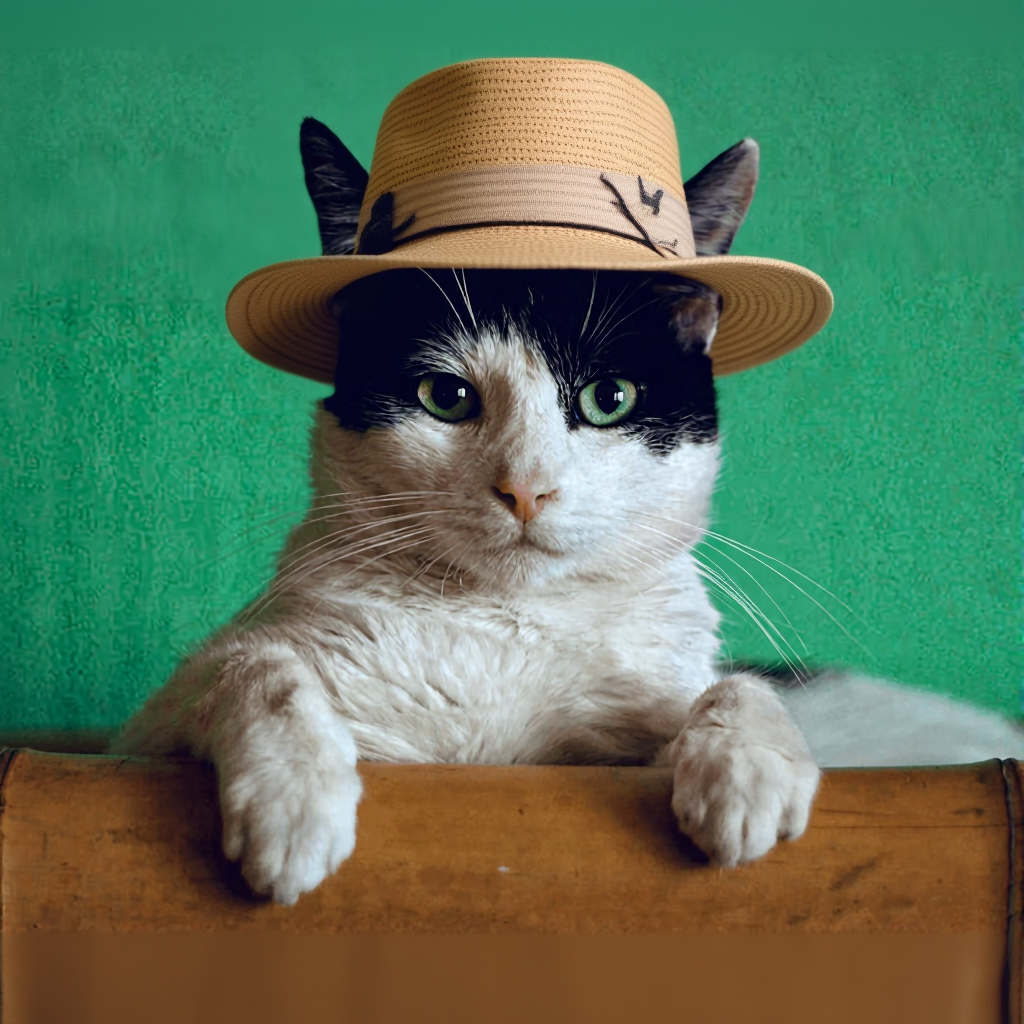

In [12]:
from IPython.display import display
display(image)